### Introduction
This problem will look at using Gibb’s sampling for two different simulation strategies
in hierarchical models. The two simulations have different goals, and the
strategies will reflect these goals. At the end of this question we'll compare
and contrast the goals, the strategies, and the models we choose to represent them.

In [13]:
%pylab inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
import seaborn as sns
import statistics

Populating the interactive namespace from numpy and matplotlib


### Background set up
There is a bike rideshare company that rents out bikes in a certain town, and they’d like to estimate the number of bikes that will be rented on a given day, so that they know how many bikes to bring in to the shop for service (if it’s projected to be a slow day for bike rentals, the company will service more bikes on thatday). We have a prior belief that people will be more or less likely to rent bikes from the rideshare company depending on **(a) the weather**, and **(b) whether** it is a working day, or a weekend day.

<img src="figure1.png" alt="Drawing" width= "400">

### (a) Data loading
To get started, import the dataset in bikeshare.csv. Each row corresponds to a unique day with the following associated information:

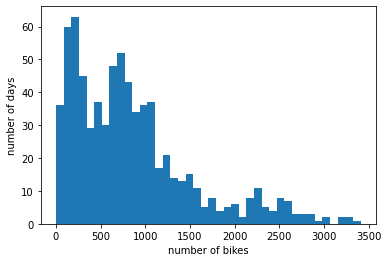

In [104]:
# Load bikeshare.csv
# The columns of the data are:
# sunny: 1 if the day was sunny, 0 otherwise.
# working_day: 1 if the day was a working day, 0 otherwise.
# month: the month the day was in, where the first month is 1.
# num_rentals: the number of people that rented a bike on the day.
data = pd.read_csv("bikeshare.csv")

plt.hist("num_rentals", data = data, bins = 40)
plt.xlabel("number of bikes")
plt.ylabel("number of days")
plt.show()

### (b) Gibb's sampling tool functions
Now we’ll use Gibb’s sampling to generate samples from the hierarchical
model described in Figure 1. We have the dataset of possible conditions and outcomes
available to us, so we’ll use that to seed the distributions in our hierarchical
model. <br/>
Specifically, given $i \in \{0, 1\}$ representing workday $(i = 1)$ or weekend $(i = 0)$ and
$j \in \{0, 1\}$ representing a sunny day $(j = 1)$ or a rainy day $(j = 0)$, we will model
the number of bike rentals on a day $x$ as:
<div align = "center"> $\mathbb{P}(x|workday = i, sunny = j) \sim N(\bar\mu_{ij} , \bar\sigma_{ij})$
    </div>
where $\mu_{ij}$ is the average number of rentals in our data set for entries that agree with
the settings $workday = i$ and $sunny = j$, and $\bar\sigma_{ij}$ is the analogous sample standard
deviation.

**(i) Calculate the means and standard deviations $\bar\mu_{ij}$ , $\bar\sigma_{ij}$ by the function get_subgroup_statistics()**

In [86]:
def get_subgroup_statistics(data):
    """
    Given bikesharing data, returns the means, standard deviations, and counts
    split by categories sunny and working_day.
    
    Parameters
    ----------
    data : dataframe
        A dataframe of bikesharing data with 0/1 categories `sunny` and `working_day`
        and numerical value `num_rentals`.
        
    Returns
    -------
    means : 2x2 array of floats
        An array where mean[i, j] corresponds to the empirical mean of rentals for
        all days with working_day=i and sunny=j.
    stds : 2x2 array of floats
        An array where stds[i, j] corresponds to the empirical standard deviation
        of rentals for all days with working_day=i and sunny=j.
    counts : 2x2 array of floats
        An array where mean[i, j] corresponds to the total number of rentals for
        all days with working_day=i and sunny=j.
    """
    num_categories = 2
    means = np.zeros((num_categories, num_categories))
    stds = np.zeros((num_categories, num_categories))
    counts = np.zeros((num_categories, num_categories))
    
    # Iterate through all possible combinations of working_day and sunny.
    for working_day in range(2):
        for sunny in range(2):
            counts[working_day, sunny] = sum((data["working_day"] == working_day) & (data["sunny"] == sunny))
    
            means[working_day, sunny] = mean(data.loc[(data["sunny"] == sunny) & 
                                                      (data["working_day"] == working_day)]["num_rentals"])
            stds[working_day, sunny] = statistics.stdev(data.loc[(data["sunny"] == sunny) & 
                                                       (data["working_day"] == working_day)]["num_rentals"])

    return means, stds, counts

In [87]:
means, stds, counts = get_subgroup_statistics(data)
print("counts: ")
print("         rainly     sunny")
print("weekend   {0}      {1}".format(counts[0,0],counts[0,1]))
print("workday   {0}      {1}".format(counts[1,0],counts[1,1]))

counts: 
         rainly     sunny
weekend   75.0      156.0
workday   193.0      307.0


In [89]:
print("means: ")
print("         rainly                   sunny")
print("weekend   {0}                 {1}".format(means[0,0],means[0,1]))
print("workday   {0}      {1}".format(means[1,0],means[1,1]))

means: 
         rainly                   sunny
weekend   1136.84                 1483.775641025641
workday   458.07253886010363      699.9250814332247


In [90]:
print("stds: ")
print("         rainly                   sunny")
print("weekend   {0}       {1}".format(stds[0,0],stds[0,1]))
print("workday   {0}      {1}".format(stds[1,0],stds[1,1]))

stds: 
         rainly                   sunny
weekend   829.6177569837224       873.5823876704324
workday   358.70131046230483      382.8249539270632


**(ii) The simulation sampling procedure proceeds as follows. For T rounds, do the following:**<br/>
1. Set $p_{sun}$ to be the fraction of sunny days you see in the dataset. Set $p_{workday} = \frac{5}{7}$.
2. Sample $i \sim Bernoulli(p_{sun})$, $j \sim Bernoulli(p_{workday})$.
3. Sample $x \sim N(\bar\mu_{ij} , \bar\sigma_{ij})$
4. Append $x$ to the sample of simulated rental counts.


In [93]:
def sample_num_rentals(workday, sunny, means, stds):
    """
    Randomly sample the number of bike rentals from one of four Gaussians depending
    on the given daily conditions.
    
    Parameters
    ----------
    workday : int
        1 if the day we wish to sample for is a workday, 0 if it's a weekend.
    sunny : int
        1 if the day we wish to sample for is sunny, 0 if it's rainy.
    means : 2x2 array of floats
        An array where mean[i, j] corresponds to the mean of the Gaussian
        we sample from when working_day=i and sunny=j.
    stds : 2x2 array of floats
        An array where mean[i, j] corresponds to the standard deviation of the Gaussian
        we sample from when working_day=i and sunny=j.
        
    Returns
    -------
    count : float
        A Gaussian sampled count.
    """
    mu, sigma = means[workday, sunny], stds[workday, sunny]
    return np.random.normal(mu, sigma, 1)


def simulate_rentals(num_samples, p_workday, p_sunny, means, stds):
    """
    Simulate `num_samples` days by using the sampling procedure defined
    in the homework sheet.
    
    Parameters
    ----------
    num_samples : int
        The number of days to simulate.
    p_workday : float
        The probability that any given day will be a workday.
    p_sunny : float
        The probability that any given day will be sunny.
    means : 2x2 array of floats
        An array where mean[i, j] corresponds to the mean of the Gaussian
        we sample from for the number of rentals when working_day=i and sunny=j.
    stds : 2x2 array of floats
        An array where stds[i, j] corresponds to the standard deviation of the Gaussian
        we sample from for the number of rentals when working_day=i and sunny=j.
        
    Returns
    -------
    samples : num_samples x 3 array of floats
        The generated samples where samples[i, 0] is 1 if day i was a workday,
        samples[i, 1] is 1 if day i was sunny, and samples[i, 2] is the number
        of rentals that happened on that day.
    """
    samples = np.zeros((num_samples, 3))
    for t in range(num_samples):
        x_t = np.zeros(3)
        x_t[0] = np.random.binomial(n = 1, p = p_workday)
        x_t[1] = np.random.binomial(n = 1, p = p_sunny)
        x_t = x_t.astype(int)
        x_t[2] = sample_num_rentals(x_t[0], x_t[1], means, stds)
        samples[t] = x_t
        
    return samples

### (c) A few simulation cases
Draw 1000 samples; plot the histogram of the resulting draws for the number of bikes in a given day.

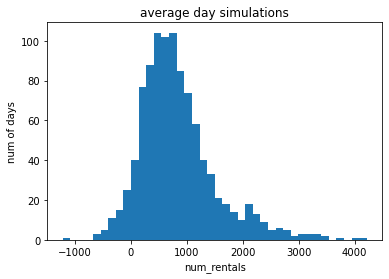

In [97]:
# Assume a 5 day workweek; ignore holidays.
p_workday = 5.0 / 7.0

# Use the fraction of sunny days from your dataset.
frac_sunny_days = len(data.loc[data["sunny"] == 1]) / len(data)
p_sunny = frac_sunny_days

# Get the data statistics.
means, stds, counts = get_subgroup_statistics(data)

T = 1000
samples = simulate_rentals(num_samples=T,
                           p_workday=p_workday,
                           p_sunny=p_sunny,
                           means=means,
                           stds=stds)

# Plot the histogram.
plt.hist(samples[:, 2], bins=40)
plt.xlabel("num_rentals");
plt.ylabel("num of days");
plt.title("average day simulations")
plt.show()

**Let’s say the forecast tomorrow says there’s an 80% chance of rain. Change $p_{sunny}$ to reflect this probability (ignoring any previous rates of rain). Run 1000 simulations with this new probability of rain.**

**(i) if tommorrow is a weekday**

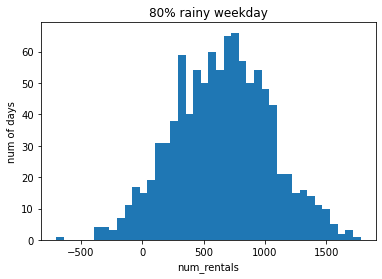

In [105]:
p_workday = 1
p_sunny = 0.8

T = 1000
samples = simulate_rentals(num_samples=T,
                           p_workday=p_workday,
                           p_sunny=p_sunny,
                           means=means,
                           stds=stds)

plt.hist(samples[:, 2], bins=40)
plt.xlabel("num_rentals");
plt.ylabel("num of days");
plt.title("80% rainy weekday")
plt.show()

**(ii) if tommorrow is a weekend**

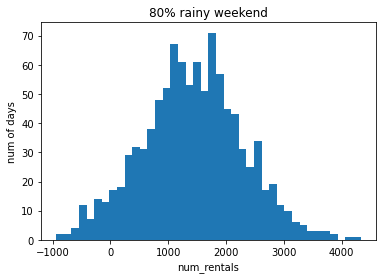

In [106]:
p_workday = 0
p_sunny = 0.8

T = 1000
samples = simulate_rentals(num_samples=T,
                           p_workday=p_workday,
                           p_sunny=p_sunny,
                           means=means,
                           stds=stds)

plt.hist(samples[:, 2], bins=40)
plt.xlabel("num_rentals");
plt.ylabel("num of days");
plt.title("80% rainy weekend")
plt.show()

### (d) New Strategy
Now, we’ll switch strategy slightly. Rather than incorporating our dataset
to seed individual probabilities governing each of the parameters $\mu_{00}, \mu_{01}, \mu_{10}, \mu_{11}$,
we’ll use the data to sample from the joint distribution on $P(x, \theta)$, where $x$ is now
a dataset of observations. Recall that 
<div align = "center">$P(x, \theta) = P(x|\theta)P(\theta)$
    </div>
where $ \theta = [\mu_{00}, \mu_{01}, \mu_{10}, \mu_{11}]$, and $x \in R^n$ is the number of rentals on each day.
Similarly to before, we’ll model the likelihood as a set of Normal distribution. Let $s_i \in \{0, 1\}$, $w_i \in \{0, 1\}$ denote whether the $i^{th}$ day in the dataset was sunny, and a
workday, respectively. Then we model the likelihood for the rental counts of that
day as: 
<div align = "center">$P(x_i|\theta) \in N(\mu_{w_i,s_i},\theta_{w_i,s_i})$
    </div>
We’ll also put independent prior probabilities on each of the means: <br/>
$P(\theta) = P(\mu_{00}, \mu_{01}, \mu_{10}, \mu_{11}) = P(\mu_{00})P(\mu_{01})P(\mu_{10})P(\mu_{11})$ as normal with specified means and standard deviations.

Using the prior probabilities and the likelihood, we will now use the following sample
procedure. <br/>
For $t = 1, ...,T$:
1. Sample $\mu_{00} \sim P(\mu_{00}), \mu_{01} \sim P(\mu_{01}), \mu_{10} \sim P(\mu_{10})$, and $\mu_{11} \sim P(\mu_{11})$.
2. Compute $l = P(x, \theta)$.
3. Append $[\mu_{00}, \mu_{01}, \mu_{10}, \mu_{11}, l]$ to the sample.

In [109]:
def sample_mu_by_category(prior_means, prior_sigma, working_day, sunny):
    """
    Sample mu from a Gaussian prior that depends on the properties of the day.
    
    Parameters
    ----------
    prior_means : 2x2 array of floats
        The prior means where prior_means[i, j] is the prior mean for days
        with working_day=i and sunny=j.
    prior_sigma : float
        The standard deviation of the prior from which we are sampling.
    working_day : int
        1 if we are sampling the mean for a day that is a workday and 0 for
        a day that is a weekend.
    sunny : int
        1 if we are sampling the mean for a day that is sunny and 0 for
        a day that is rainy.
        
    Returns
    -------
    mu : float
        The sampled mean.
    """
    prior_mean = prior_means[working_day][sunny]
    return np.random.normal(prior_mean, prior_sigma)


def prior_prob_by_category(observed_mu, prior_means, prior_sigma, working_day, sunny):
    """
    Compute the probability that we observed mu given specific properties of the day.
    
    Parameters
    ----------
    observed_mu : float
        The value of mu for which we wish to compute the prior probability.
    prior_means : 2x2 array of floats
        The prior means where prior_means[i, j] is the prior mean for days
        with working_day=i and sunny=j.
    prior_sigma : float
        The standard deviation of the prior from which we are sampling.
    working_day : int
        1 if we are sampling the mean for a day that is a workday and 0 for
        a day that is a weekend.
    sunny : int
        1 if we are sampling the mean for a day that is sunny and 0 for
        a day that is rainy.
        
    Returns
    -------
    prob : float
        The computed probability.
    """
    prior_mean = prior_means[working_day][sunny]
    return scipy.stats.norm(prior_mean,prior_sigma).pdf(observed_mu)


def compute_likelihood(data, likelihood_means, likelihood_sigma):
    """
    Compute the likelihood that we observed the data given the
    means across the four daily categories.
    
    Parameters
    ----------
    data : dataframe
        A dataframe of bikesharing data with 0/1 categories `sunny` and `working_day`
        and numerical value `num_rentals`.
    likelihood_means : 2x2 array of floats
        The likelihood means where sampled_means[i, j] is the likelihood mean when
        work_day=i and sunny=j.
    likelihood_sigma : float
        The standard deviations of the Gaussians from which the data is drawn.

    Returns
    -------
    prob : float
        The likelihood of the data, may be scaled by a fixed constant.
    """
    sunny = data["sunny"].values
    working_day = data["working_day"].values
    num_rentals = data["num_rentals"].values
    
    likelihood = 1
    # Assume draws are i.i.d. so that likelihoods of each datapoint multiply.
    for i in range(len(data)):
        x = num_rentals[i]
        # mu_this_category is the sampled mean for the sunny/workday combo of row i.
        mu_this_category = likelihood_means[working_day[i], sunny[i]]

        # Premultiply by 1e4 to keep numerical stability, 
        # because data is the same length every time this will be ok.
        likelihood *= 1e4 * scipy.stats.norm(mu_this_category, likelihood_sigma).pdf(x)
        
    return likelihood

def gibbs_sampling_posterior(data, num_samples, prior_means, prior_sigma, likelihood_sigma):
    """
    Sample likelihood parameters (the means) along with their posterior probability.
    
    Parameters
    ----------
    num_samples : int
        The number of samples to draw.
    prior_means : 2x2 array of floats
        The prior means associated to the likelihood means, where prior_means[i, j]
        is the prior mean for working_day=i and sunny=j.
    prior_sigma : float
        The standard deviation of all the prior Gaussians.
    likelihood_sigma : float
        The standard deviation of all the likelihood Gaussians.
    
    Returns
    -------
    samples : num_samples x 5 array of floats
        The array of all generated samples where samples[i] is the subarray with
        [mu_sunny_workday, mu_rainy_workday, mu_sunny_weekend, mu_rainy_weekend, c*p(theta, x)]
        where the last element is the posterior scaled by any arbitrary positive constant.
    """
    samples = np.zeros((num_samples, 5))
    for t in range(num_samples):
        # Sample the likelihood parameters.
        mu_sunny_workday = sample_mu_by_category(prior_means, prior_sigma, 1, 1) 
        mu_sunny_weekend = sample_mu_by_category(prior_means, prior_sigma, 0, 1)
        mu_rainy_workday = sample_mu_by_category(prior_means, prior_sigma, 1, 0)
        mu_rainy_weekend = sample_mu_by_category(prior_means, prior_sigma, 0, 0)
        
        # Now compute the likelihood.
        theta = np.array([[mu_rainy_weekend, mu_sunny_weekend],
                          [mu_rainy_workday, mu_sunny_workday]])
        likelihood = compute_likelihood(data, theta, likelihood_sigma)
        
        # Compute P(theta).
        p_theta = prior_prob_by_category(mu_sunny_workday, prior_means, prior_sigma, 1, 1) *prior_prob_by_category(mu_sunny_weekend, prior_means, prior_sigma, 0, 1)*prior_prob_by_category(mu_rainy_workday, prior_means, prior_sigma, 1, 0)*prior_prob_by_category(mu_rainy_weekend, prior_means, prior_sigma, 0, 0)
    
        # Save the sample.
        x_t = np.zeros(5)
        x_t[0] = mu_sunny_workday
        x_t[1] = mu_rainy_workday
        x_t[2] = mu_sunny_weekend
        x_t[3] = mu_rainy_weekend
        x_t[4] = likelihood*p_theta
        samples[t] = x_t

    return np.array(samples)

### (g) 
Plot the estimated distributions of the posterior marginals $P(\mu_{00}), P(\mu_{01}), P(\mu{10})$,
and $P(\mu_{11})$ from your sample. To do so a histogram of each draw of each mean
is plotted, weighted by the calculated posterior density associated with that
draw. <br/><br/>
For comparison purpose. We'll first plot the distribution of $n = 10$ data points, and then $n = 100$ datapoints from the total data.

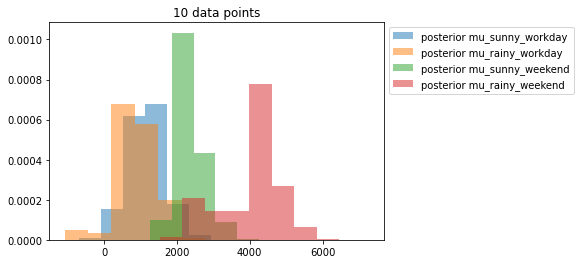

In [114]:
mu_rainy_weekend_prior = 4000
mu_rainy_workday_prior = 2000

mu_sunny_weekend_prior = 4000
mu_sunny_workday_prior = 2000

prior_sigma = 1000
likelihood_sigma = 1000

prior_means = np.array([[mu_rainy_weekend_prior, mu_sunny_weekend_prior],
                        [mu_rainy_workday_prior, mu_sunny_workday_prior]])

samples = gibbs_sampling_posterior(data[:10],
                                   num_samples=1000,
                                   prior_means=prior_means,
                                   prior_sigma=prior_sigma,
                                   likelihood_sigma=likelihood_sigma)

fig, ax = plt.subplots()

ax.hist(samples[:,0], weights=samples[:,4], label="posterior mu_sunny_workday", density=True, alpha=0.5)
ax.hist(samples[:,1], weights=samples[:,4], label="posterior mu_rainy_workday", density=True, alpha=0.5)
ax.hist(samples[:,2], weights=samples[:,4], label="posterior mu_sunny_weekend", density=True, alpha=0.5)
ax.hist(samples[:,3], weights=samples[:,4], label="posterior mu_rainy_weekend", density=True, alpha=0.5)

ax.legend(bbox_to_anchor=(1, 1))

plt.title("10 data points")
plt.show()

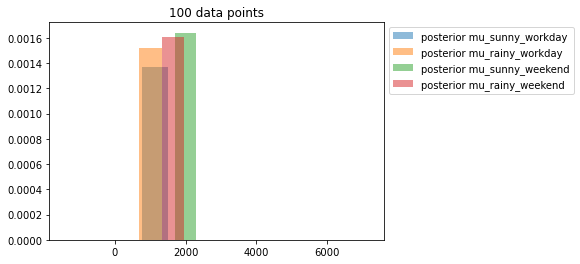

In [115]:
mu_rainy_weekend_prior = 4000
mu_rainy_workday_prior = 2000

mu_sunny_weekend_prior = 4000
mu_sunny_workday_prior = 2000

prior_sigma = 1000
likelihood_sigma = 1000

prior_means = np.array([[mu_rainy_weekend_prior, mu_sunny_weekend_prior],
                        [mu_rainy_workday_prior, mu_sunny_workday_prior]])

samples = gibbs_sampling_posterior(data[:100],
                                   num_samples=1000,
                                   prior_means=prior_means,
                                   prior_sigma=prior_sigma,
                                   likelihood_sigma=likelihood_sigma)

fig, ax = plt.subplots()

ax.hist(samples[:,0], weights=samples[:,4], label="posterior mu_sunny_workday", density=True, alpha=0.5)
ax.hist(samples[:,1], weights=samples[:,4], label="posterior mu_rainy_workday", density=True, alpha=0.5)
ax.hist(samples[:,2], weights=samples[:,4], label="posterior mu_sunny_weekend", density=True, alpha=0.5)
ax.hist(samples[:,3], weights=samples[:,4], label="posterior mu_rainy_weekend", density=True, alpha=0.5)

ax.legend(bbox_to_anchor=(1, 1))

plt.title("100 data points")
plt.show()

### Summary
We are sampling the distributions of num_bikerentals under different workday and weather status. We noticed that even with a small sample(as small as 10), Gibb's samping gives an okay level of simulation of distribution of the means by utilizing the prior distribution means and standard deviations. 